In [ ]:
## Fine-Tune the Swin Model (Vision Transformer) on Multi-label Image Classification

In [21]:
!pip install -Uq transformers datasets timm accelerate evaluate

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.transforms as T

from pathlib import Path
from PIL import Image

import datasets

from transformers.optimization import get_cosine_schedule_with_warmup
from timm import list_models , create_model
from accelerate import Accelerator, notebook_launcher

import evaluate


In [23]:
dataset = datasets.load_dataset('fuliucansheng/pascal_voc','voc2007_main')

In [24]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'image', 'height', 'width', 'classes', 'objects'],
        num_rows: 2501
    })
    validation: Dataset({
        features: ['id', 'image', 'height', 'width', 'classes', 'objects'],
        num_rows: 2510
    })
    test: Dataset({
        features: ['id', 'image', 'height', 'width', 'classes', 'objects'],
        num_rows: 4952
    })
})

In [25]:
class_names = [
    "Aeroplane","Bicycle","Bird","Boat","Bottle",
    "Bus","Car","Cat","Chair","Cow","Diningtable",
    "Dog","Horse","Motorbike","Person",
    "Potted plant","Sheep","Sofa","Train","Tv/monitor"
]

In [26]:
label2id = {c:idx for idx, c in enumerate(class_names)}
id2label = {idx:c for idx, c in enumerate(class_names)}

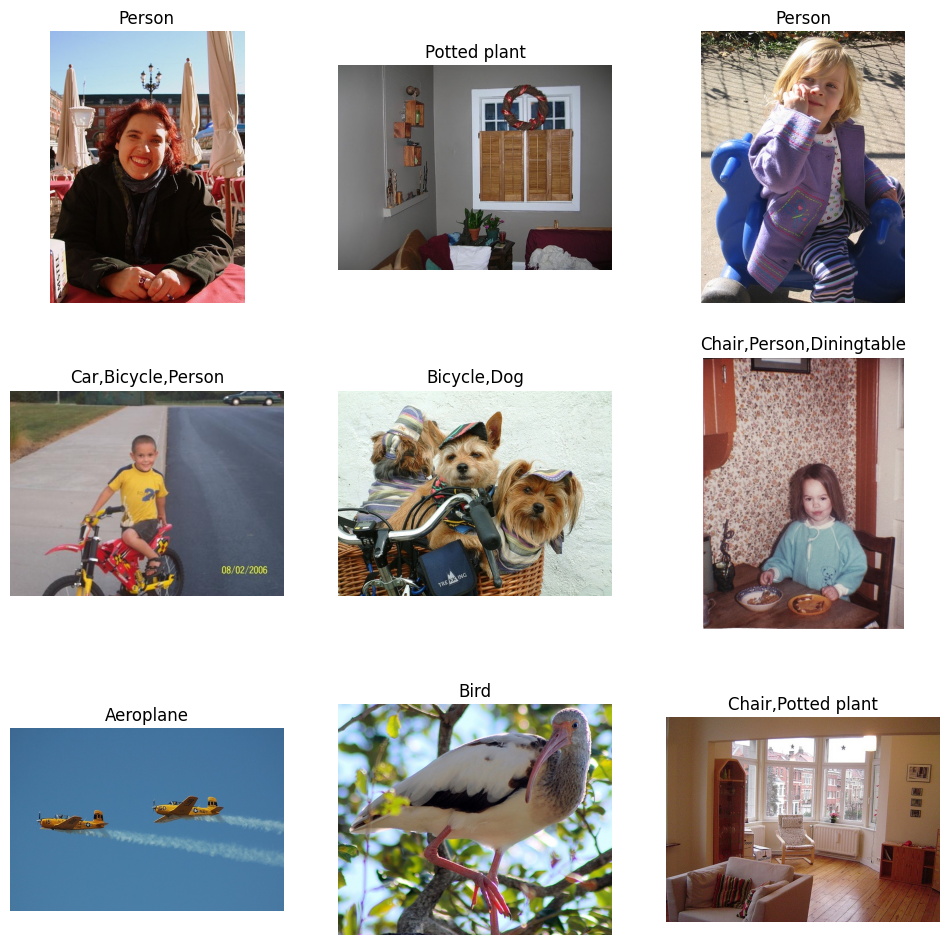

In [27]:
def show_samples(ds , rows , cols):
  samples = ds.shuffle().select(np.arange(rows*cols))
  fig = plt.figure(figsize = (cols*4 , rows*4))

  for i in range(rows*cols):
    img = samples[i]['image']
    labels = samples[i]['classes']
    labels = ','.join([id2label[lb] for lb in labels])
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(img)
    plt.title(labels)
    plt.axis('off')

show_samples(dataset['train'] , 3,3)

In [28]:
img_size = (224,224)

train_tfms = T.Compose([
    T.Resize(img_size),
    T.RandomHorizontalFlip(),
    T.RandomRotation(30),
    T.CenterCrop(img_size),
    T.ToTensor(),
    T.Normalize(
        mean = (0.5 , 0.5 , 0.5),
        std = (0.5 , 0.5 , 0.5)
    )
  ])

valid_tfms = T.Compose([
    T.Resize(img_size),
    T.ToTensor(),
    T.Normalize(
        mean = (0.5 , 0.5 , 0.5),
        std = (0.5 , 0.5 , 0.5)
    )
])


In [29]:
def train_transforms(batch):
    # Image processing (adjust train_tfms as needed)
    batch['image'] = [x.convert('RGB') for x in batch['image']]
    inputs = [train_tfms(x) for x in batch['image']]
    batch['pixel_values'] = torch.stack(inputs)

    # Label processing
    batch_size = len(batch['classes'])
    num_classes = 20
    batch_labels = torch.zeros(batch_size, num_classes, dtype=torch.float32)

    for i, cls in enumerate(batch['classes']):
        if cls:  # Handle empty lists
            for idx in cls:
                if 0 <= idx < num_classes:  # Ensure valid index
                    batch_labels[i, idx] = 1

    batch['labels'] = batch_labels
    return batch


def valid_transforms(batch):
    # Image processing (adjust train_tfms as needed)
    batch['image'] = [x.convert('RGB') for x in batch['image']]
    inputs = [valid_tfms(x) for x in batch['image']]
    batch['pixel_values'] = torch.stack(inputs)

    # Label processing
    batch_size = len(batch['classes'])
    num_classes = 20
    batch_labels = torch.zeros(batch_size, num_classes, dtype=torch.float32)

    for i, cls in enumerate(batch['classes']):
        if cls:  # Handle empty lists
            for idx in cls:
                if 0 <= idx < num_classes:  # Ensure valid index
                    batch_labels[i, idx] = 1

    batch['labels'] = batch_labels
    return batch


In [30]:
train_dataset = dataset['train'].with_transform(train_transforms)
valid_dataset = dataset['validation'].with_transform(valid_transforms)
test_dataset = dataset['test'].with_transform(valid_transforms)

len(train_dataset), len(valid_dataset), len(test_dataset)

(2501, 2510, 4952)

In [31]:
def collate_fn(batch):
  return {
      'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
      'labels': torch.stack([x['labels'] for x in batch]).float()
  }

In [32]:
def param_count(model):
    params = [(p.numel(),p.requires_grad) for p in model.parameters()]
    trainable = sum([count for count,trainable in params if trainable])
    total = sum([count for count,_ in params])
    frac = (trainable / total) * 100
    return total, trainable, frac

In [ ]:
import time

In [35]:
def train_without_LoRA(model_name , batch_size = 16 , epochs = 1 , lr = 2e-4):

  accelerator = Accelerator()

  train_dl = torch.utils.data.DataLoader(
      train_dataset,
      batch_size = batch_size,
      shuffle = True,
      num_workers = 4,
      collate_fn = collate_fn
  )

  valid_dl = torch.utils.data.DataLoader(
      valid_dataset ,
      batch_size = batch_size*2,
      shuffle = True,
      num_workers = 4,
      collate_fn = collate_fn
  )

  test_dl = torch.utils.data.DataLoader(
        test_dataset,
        batch_size = batch_size*2,
        shuffle=False,
        num_workers=4,
        collate_fn=collate_fn
    )

  model = create_model(
      model_name,
      pretrained = True,
      num_classes = 20
  ).to(accelerator.device)

  total , trainable , frac = param_count(model)
  accelerator.print(f"{total = :,} | {trainable = :,} | {frac:.2f}%")

  loss_fn = nn.BCEWithLogitsLoss()

  optimizer = torch.optim.AdamW(model.parameters(), lr=lr , weight_decay = 0.02)

  scheduler = get_cosine_schedule_with_warmup(
      optimizer,
      num_warmup_steps = int(0.1*len(train_dl)),
      num_training_steps = len(train_dl)
  )

  model , optimizer , scheduler , train_dl , valid_dl , test_dl = accelerator.prepare(
      model , optimizer , scheduler , train_dl , valid_dl , test_dl
  )
  start_time = time.time()
  for epoch in range(1,epochs+1):
    model.train()
    train_metrics = evaluate.load('roc_auc','multilabel')
    running_loss = 0

    for batch in train_dl:
      logits = model(batch['pixel_values'])

      loss = loss_fn(logits , batch['labels'])
      accelerator.backward(loss)
      optimizer.step()
      scheduler.step()
      optimizer.zero_grad()

      running_loss += loss.item()

      logits , labels = accelerator.gather_for_metrics(
          (logits , batch['labels'])
      )

      train_metrics.add_batch(references=labels, prediction_scores=logits)

    train_loss = running_loss/len(train_dl)
    train_roc_auc = train_metrics.compute(average = 'micro')['roc_auc']

    accelerator.print(f"\n{epoch = }")
    accelerator.print(f"{train_loss = :.3f} | {train_roc_auc = :.3f}")

    model.eval()
    running_loss = 0
    valid_metrics = evaluate.load('roc_auc' , 'multilabel')

    for batch in valid_dl:
      with torch.no_grad():
        logits = model(batch['pixel_values'])

      loss = loss_fn(logits , batch['labels'])
      running_loss += loss.item()

      logits , labels = accelerator.gather_for_metrics(
          (logits , batch['labels'])

      )
      valid_metrics.add_batch(references = labels , prediction_scores = logits)

    valid_loss = running_loss/len(valid_dl)
    valid_roc_auc = valid_metrics.compute(average = 'micro')['roc_auc']

    accelerator.print(f"{valid_loss = :.3f} | {valid_roc_auc = :.3f}")

    accelerator.save_model(model , f'./{model_name}-pascal')

    test_metric = evaluate.load('roc_auc' , 'multilabel')
    for batch in test_dl:
      with torch.no_grad():
        logits = model(batch['pixel_values'])

      logits , labels = accelerator.gather_for_metrics(
          (logits , batch['labels'])
      )
      test_metric.add_batch(references = labels , prediction_scores = logits)

    test_roc_auc = test_metric.compute(average = 'micro')['roc_auc']
    accelerator.print(f"\n\nTEST AUROC: {test_roc_auc = :.3f}")

  end_time = time.time()
  total_time = end_time-start_time
  accelerator.print(f"\nTotal training time: {total_time:.2f} seconds")


In [38]:
model_name = 'swin_s3_base_224'


In [39]:
notebook_launcher(train_without_LoRA , (model_name , 8 , 5 , 5e-5) , num_processes = 1)

Launching training on one GPU.


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


total = 70,372,142 | trainable = 70,372,142 | 100.00%

epoch = 1
train_loss = 0.172 | train_roc_auc = 0.899


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


valid_loss = 0.088 | valid_roc_auc = 0.983


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(




TEST AUROC: test_roc_auc = 0.983


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



epoch = 2
train_loss = 0.079 | train_roc_auc = 0.983


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


valid_loss = 0.062 | valid_roc_auc = 0.988


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(




TEST AUROC: test_roc_auc = 0.988


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



epoch = 3
train_loss = 0.047 | train_roc_auc = 0.994


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


valid_loss = 0.048 | valid_roc_auc = 0.993


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(




TEST AUROC: test_roc_auc = 0.992


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



epoch = 4
train_loss = 0.043 | train_roc_auc = 0.994


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


valid_loss = 0.050 | valid_roc_auc = 0.992


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(




TEST AUROC: test_roc_auc = 0.991


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



epoch = 5
train_loss = 0.027 | train_roc_auc = 0.998


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


valid_loss = 0.045 | valid_roc_auc = 0.993


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(




TEST AUROC: test_roc_auc = 0.992

Total training time: 977.36 seconds


In [ ]:

model = create_model(
    model_name,
    num_classes = 20
)

In [ ]:
!pip install safetensors

In [ ]:
from safetensors.torch import load_model

In [ ]:
#load_model(model, '/content/model.safetensors')

load_model(model,f'./{model_name}-pascal/model.safetensors')

(set(), [])

In [ ]:
def show_predictions(rows=2 , cols=4):
  model.eval()
  samples = test_dataset.shuffle().select(np.arange(rows*cols))
  fig = plt.figure(figsize = (cols*4 , rows*4))

  for i in range(rows*cols):
    img = samples[i]['image']
    inputs = samples[i]['pixel_values'].unsqueeze(0)
    labels = samples[i]['classes']
    labels = ','.join([id2label[lb] for lb in labels])

    with torch.no_grad():
      logits = model(inputs)

    predictions = logits.sigmoid() > 0.5

    predictions = predictions.float().numpy().flatten()
    pred_labels = np.where(predictions==1)[0]
    pred_labels = ','.join([id2label[label] for label in pred_labels])

    label = f"label: {labels}\npredicted: {pred_labels}"
    fig.add_subplot(rows,cols,i+1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

show_predictions(5,5)